In [2]:
import time
import pandas as pd
import numpy as np  
import torch  
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
from torch.utils.data import DataLoader, TensorDataset  
from collections import Counter  
from sklearn.metrics import accuracy_score, classification_report 
from scipy.io import loadmat  
from sklearn.preprocessing import MinMaxScaler  

# Data Load: IMS Dataset

In [75]:
def data_load(label,filename,column_name):
    
    data = pd.read_csv(f'{filename}'+'.csv')
    org_DE = data[column_name]
    org_DE=org_DE.to_frame()
    scaler = MinMaxScaler()
    list_DE_n = scaler.fit_transform(org_DE)
    list_DE = [de[0] for de in list_DE_n]
    data_samples = []
    labels = []
    print(len(list_DE))
    for i in range(0, 12280000, 400):
        segment = list_DE[i:i+400]
        if len(segment) < 400:
            break
        segment_array = np.array(segment).reshape((20, 20))
        data_samples.append(segment_array)
        labels.append(label)
    return data_samples, labels
data_list=[0]*4
label_list=[0]*4
data_list[0],label_list[0]=data_load(0,'train_data/ims_1','Normal')
data_list[1],label_list[1]=data_load(1,'train_data/ims_1','Inner')
data_list[2],label_list[2]=data_load(2,'train_data/ims_1','Ball')
data_list[3],label_list[3]=data_load(3,'train_data/ims_3','Outer')
data_train=np.asarray(data_list[0]+data_list[1]+data_list[2]+data_list[3],dtype='float64')
label=np.asarray(label_list[0]+label_list[1]+label_list[2]+label_list[3],dtype='int64')
print("数据样本shape:", data_train.shape)
print(label.shape)
print("数据类别数量:", len(np.unique(label)))


1228800
1228800
1228800
1228800
数据样本shape: (12288, 20, 20)
(12288,)
数据类别数量: 4


In [76]:
np.save("train_data/data_2d_10class.npy", data_train)  
np.save("train_data/labels_2d_10class.npy", label)  
print("数据保存成功，位置：train_data/")  

数据保存成功，位置：train_data/


In [117]:
import numpy as np  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import DataLoader, TensorDataset  
from collections import Counter  

# Step 1: 数据准备  
def load_data():  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    assert x.shape[0] == y.shape[0], "Mismatch between data samples and labels"  
    num_classes = len(Counter(y))  
    print("类别数量为：", num_classes)  
    print("数据样本shape:", x.shape)  
    print("类分布：", Counter(y))  
    return x, y, num_classes  

def create_train_data(x, y, ratio=0.8):  
    num_example = x.shape[0]  
    arr = np.arange(num_example)  
    np.random.seed(50)  
    np.random.shuffle(arr)  
    arr_data = x[arr]  
    arr_label = y[arr]  

    s = int(num_example * ratio)  
    x_train = arr_data[:s]  
    y_train = arr_label[:s]  
    x_val = arr_data[s:]  
    y_val = arr_label[s:]  

    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_val.shape)  
    print("测试集类别：", Counter(y_val))  
    return x_train, y_train, x_val, y_val  

def create_loaders(train_data, train_label, val_data, val_label, batch_size):  
    train_data_tensor = torch.from_numpy(train_data).float()  
    train_label_tensor = torch.from_numpy(train_label).long()  
    val_data_tensor = torch.from_numpy(val_data).float()  
    val_label_tensor = torch.from_numpy(val_label).long()  

    train_dataset = TensorDataset(train_data_tensor, train_label_tensor)  
    val_dataset = TensorDataset(val_data_tensor, val_label_tensor)  

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  

    return train_loader, val_loader  

# Step 2: LSTM Model Definition  
class LSTMModel(nn.Module):  
    def __init__(self, input_size=20, hidden_size=64, num_classes=4):  
        super(LSTMModel, self).__init__()  
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu=nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(64)     # Batch Normalization层
        self.fc2 = nn.Linear(64, num_classes)   # 第二个全连接层

    def forward(self, x):  
        out, (hn, cn) = self.lstm(x)  
        out = out[:, -1, :]  # We take the output of the last time step  
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batchnorm(out)
        out = self.fc2(out)
        
        return out  


# Load and prepare data  
x, y, num_classes = load_data()  
x_train, y_train, x_val, y_val = create_train_data(x, y, 0.8)  
train_loader, val_loader = create_loaders(x_train, y_train, x_val, y_val, batch_size=32)  

# Instantiate the LSTM model  
model = LSTMModel(input_size=20, hidden_size=64, num_classes=num_classes)  

# Define criterion and optimizer  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.7)
# Training loop  

# 早停机制相关变量  
patience = 2  # 设定耐心值为2次  
# best_accuracy = 0.0  # 最好的验证准确率  
trigger_times = 0  # 触发早停的次数  

# 训练循环  
num_epochs = 50  

train_accuracies = []  
val_accuracies = []  
t1=time.time()
for epoch in range(num_epochs):  
    running_loss = 0.0  
    correct_predictions = 0  
    model.train()  
    for inputs, labels in train_loader:  
            optimizer.zero_grad()  
            outputs = model(inputs)   
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            
            running_loss += loss.item() * inputs.size(0)  
            _, preds = torch.max(outputs, 1)  
            correct_predictions += torch.sum(preds == labels.data)  
            
    epoch_loss = running_loss / len(train_loader.dataset)  
    epoch_acc = correct_predictions.double() / len(train_loader.dataset)  
    train_accuracies.append(epoch_acc.item())  # 记录训练准确率  

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")  
    
    # 评估模型在验证集上的表现  
    model.eval()  
    correct_predictions = 0  

    with torch.no_grad():  
        for inputs, labels in val_loader:  
            outputs = model(inputs)  
            _, preds = torch.max(outputs, 1)  
            correct_predictions += torch.sum(preds == labels.data)  
            
    epoch_val_acc = correct_predictions.double() / len(val_loader.dataset)  
    val_accuracies.append(epoch_val_acc.item())  # 记录验证准确率  
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {epoch_val_acc:.4f}") 
    # 早停机制  
    if epoch_val_acc >= 0.95:  
        trigger_times += 1  
    else:
        trigger_times = 0
    if trigger_times >= patience:  # 达到耐心值则早停  
        print("验证准确率连续两次达到0.95以上,提前停止训练")
        
        break
t2=time.time()
train_time=t2-t1
print(f'train time: {train_time} s')

类别数量为： 4
数据样本shape: (12288, 20, 20)
类分布： Counter({0: 3072, 1: 3072, 2: 3072, 3: 3072})
训练集shape (9830, 20, 20)
训练集类别： Counter({3: 2471, 1: 2469, 0: 2464, 2: 2426})
测试集shape (2458, 20, 20)
测试集类别： Counter({2: 646, 0: 608, 1: 603, 3: 601})
Epoch [1/50], Loss: 0.6200, Train Accuracy: 0.6661
Epoch [1/50], Validation Accuracy: 0.6505
Epoch [2/50], Loss: 0.3777, Train Accuracy: 0.7740
Epoch [2/50], Validation Accuracy: 0.7486
Epoch [3/50], Loss: 0.3676, Train Accuracy: 0.7860
Epoch [3/50], Validation Accuracy: 0.4919
Epoch [4/50], Loss: 0.3583, Train Accuracy: 0.7775
Epoch [4/50], Validation Accuracy: 0.2474
Epoch [5/50], Loss: 0.4061, Train Accuracy: 0.7699
Epoch [5/50], Validation Accuracy: 0.7343
Epoch [6/50], Loss: 0.3572, Train Accuracy: 0.7831
Epoch [6/50], Validation Accuracy: 0.7327
Epoch [7/50], Loss: 0.3414, Train Accuracy: 0.7847
Epoch [7/50], Validation Accuracy: 0.6957
Epoch [8/50], Loss: 0.4352, Train Accuracy: 0.7627
Epoch [8/50], Validation Accuracy: 0.7217
Epoch [9/50], Loss:

In [118]:
# 评估模型  
model.eval()  
all_labels = []  
all_predictions = []  

with torch.no_grad():  
    for inputs, labels in val_loader:  
        outputs = model(inputs)  
        _, preds = torch.max(outputs, 1)  
        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(preds.cpu().numpy())  

# 计算各项指标  
print("*****完成预处理，进行模型评估*****")  
print('------------------测试集上得分：------------------------')  

y_pred = all_predictions  
val_labels = y_val  # Assuming val_label is already available  

print('*' * 5)  
print('测试集准确率得分:', round(accuracy_score(val_labels, y_pred), 3))  
print('*' * 5)  
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_labels, y_pred))  

*****完成预处理，进行模型评估*****
------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.983
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       608
           1       1.00      1.00      1.00       603
           2       0.95      0.99      0.97       646
           3       1.00      1.00      1.00       601

    accuracy                           0.98      2458
   macro avg       0.98      0.98      0.98      2458
weighted avg       0.98      0.98      0.98      2458



In [120]:
result=classification_report(val_labels, y_pred,output_dict=True)
LSTM_info={}
LSTM_info['accuracy']=result['accuracy']
LSTM_info['precision']=result['macro avg']['precision']
LSTM_info['recall']=result['macro avg']['recall']
LSTM_info['f1-score']=result['macro avg']['f1-score']
LSTM_info['train_time']=train_time

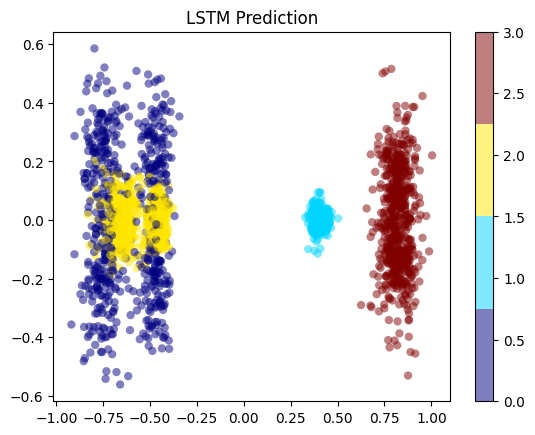

In [124]:
def plot_data(x, y, title):  
    pca = PCA(n_components = 2)  
    projected = pca.fit_transform(x)  
    plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,   
                cmap=plt.get_cmap('jet', np.unique(y).max() + 1))  
    plt.colorbar()  
    plt.title(title)  
    plt.show()  
x_test_reshaped = x_val.reshape(x_val.shape[0], -1)
plot_data(x_test_reshaped, y_pred, "LSTM Prediction")  

# CWRU

In [31]:
# 定义数据加载和处理函数  
def data_load(file_names, filename):  
    # 读取 .mat 文件  
    data = loadmat(f'{filename}.mat')  
    org_DE = data[f'X{filename}_DE_time']  
    
    # 归一化数据  
    scaler = MinMaxScaler()  
    list_DE_n = scaler.fit_transform(org_DE)  
    
    # 将数据从二维列表转换为一维列表  
    list_DE = [de[0] for de in list_DE_n]  
    
    data_samples = []  
    labels = []  
    
    # 每次采集400个点作为一个样本  
    for i in range(0, 120000, 400):  
        segment = list_DE[i:i+400]  
        if len(segment) < 400:  
            break  
        # 转换为 20x20 的矩阵  
        segment_array = np.array(segment).reshape((20, 20))  
        data_samples.append(segment_array)  
        labels.append(file_names[filename])  
    
    return data_samples, labels  

# 主程序  
file_names = {  
    '097': 0, '105': 1, '118': 2, '130': 3,  
    '169': 4, '185': 5, '197': 6, '209': 7,  
    '222': 8, '234': 9  
}  

data_list = []  
label_list = []  

# 遍历所有文件并处理数据  
for filename in file_names.keys():  
    data, label = data_load(file_names, filename)  
    data_list.extend(data[:300])  
    label_list.extend(label[:300])  

# 转换为 numpy 数组  
data = np.array(data_list, dtype='float64')  
labels = np.array(label_list, dtype='int64')  

print("数据样本shape:", data.shape)  
print("数据类别数量:", len(np.unique(labels)))  

# 保存数据  
np.save("train_data/data_2d_10class.npy", data)  
np.save("train_data/labels_2d_10class.npy", labels)  
print("数据保存成功，位置：train_data/")  

数据样本shape: (3000, 20, 20)
数据类别数量: 10
数据保存成功，位置：train_data/


# CRWU LSTM

In [93]:
import numpy as np  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import DataLoader, TensorDataset  
from sklearn.metrics import accuracy_score, classification_report  
from collections import Counter  

# Step 1: 数据准备  
def load_data():  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    print("数据样本shape:", x.shape)
    return x, y, num  

def create_train_data(x, y, ratio=0.8):  
    num_example = x.shape[0]  
    arr = np.arange(num_example)  
    np.random.seed(50)  
    np.random.shuffle(arr)  
    arr_data = x[arr]  
    arr_label = y[arr]  

    s = int(num_example * ratio)  
    x_train = arr_data[:s]  
    y_train = arr_label[:s]  
    x_val = arr_data[s:]  
    y_val = arr_label[s:]  

    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_val.shape)  
    print("测试集类别：", Counter(y_val))  
    return x_train, y_train, x_val, y_val  

def create_loaders(train_data, train_label, val_data, val_label, batch_size):  
    train_data_tensor = torch.from_numpy(train_data).float()  
    train_label_tensor = torch.from_numpy(train_label).long()  
    val_data_tensor = torch.from_numpy(val_data).float()  
    val_label_tensor = torch.from_numpy(val_label).long()  

    train_dataset = TensorDataset(train_data_tensor, train_label_tensor)  
    val_dataset = TensorDataset(val_data_tensor, val_label_tensor)  

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  

    return train_loader, val_loader  

# Step 2: LSTM 模型定义  
class LSTMModel(nn.Module):  
    def __init__(self, input_size, hidden_size, num_classes):  
        super(LSTMModel, self).__init__()  
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  
        self.fc1 = nn.Linear(hidden_size, 32)  # 第一个全连接层  
        self.fc2 = nn.Linear(32, num_classes)   # 第二个全连接层  
        self.dropout = nn.Dropout(0.2)           # Dropout层 
        self.batchnorm = nn.BatchNorm1d(32)     # Batch Normalization层

    def forward(self, x):  
        out, _ = self.lstm(x)  # LSTM层  
        out = out[:, -1, :]     # 取最后一个时间步的输出  
        out = self.fc1(out)     # 第一个全连接层  
        out = F.relu(out)       # ReLU激活  
        out = self.batchnorm(out)
        out = self.dropout(out) # Dropout  
        out = self.fc2(out) # 第二个全连接层
        # out =F.relu(out)
        
        # out = F.log_softmax(out, dim=1)  # LogSoftmax
        return out   

# Step 3: 训练和评估  
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs):  
    for epoch in range(num_epochs):  
        model.train()  
        running_loss = 0.0  
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.view(inputs.size(0), 20, 20)  # Adjust input shape  
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item()  

        epoch_loss = running_loss / len(train_loader)  
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')  

        # Step the scheduler after each epoch  
        scheduler.step()  

def evaluate_model(model, val_loader):  
    model.eval()  
    correct = 0  
    total = 0  
    all_predictions = []  
    all_labels = []  

    with torch.no_grad():  
        for inputs, labels in val_loader:  
            inputs = inputs.view(inputs.size(0), 20, 20)  # Adjust input shape  
            outputs = model(inputs)  
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
            all_predictions.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    accuracy = 100 * correct / total  
    print(f'Test Accuracy: {accuracy:.2f}%')  

    all_predictions = np.asarray(all_predictions, dtype='int64')  
    all_labels = np.asarray(all_labels, dtype='int64')  

    print('------------------测试集上得分：------------------------')  
    print('测试集准确率: ', round(accuracy_score(all_labels, all_predictions), 3))  
    print('分类报告如下:\n', classification_report(all_labels, all_predictions))
    
    return classification_report(all_labels, all_predictions, output_dict=True,zero_division=0)

# 主程序  
data, label, label_count = load_data()  
train_data, train_label, val_data, val_label = create_train_data(data, label, 0.7)  

minibatch_size = 32
train_loader, val_loader = create_loaders(train_data, train_label, val_data, val_label, minibatch_size)  

# 参数设置  
input_size = 20   # 输入特征的数量  
hidden_size = 64  # LSTM 单元的数量  
num_classes = 10  # 类别数量  
num_epochs = 50 # 训练轮数  

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)  
criterion = nn.CrossEntropyLoss()  
# 初始化学习率调度器，每 7 个 epoch 乘以 0.7  
optimizer = optim.Adam(model.parameters(), lr=0.001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.7) 

# 训练模型  
start=time.time()
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs)  
end=time.time()
train_time=end-start
print(f'train time: {train_time} s')
eval_info = evaluate_model(model, val_loader)  


类别数量为： 4
数据样本shape: (12288, 20, 20)
训练集shape (8601, 20, 20)
训练集类别： Counter({3: 2191, 1: 2171, 0: 2138, 2: 2101})
测试集shape (3687, 20, 20)
测试集类别： Counter({2: 971, 0: 934, 1: 901, 3: 881})
Epoch 1/50, Loss: 0.6261
Epoch 2/50, Loss: 0.3996
Epoch 3/50, Loss: 0.3888
Epoch 4/50, Loss: 0.3501
Epoch 5/50, Loss: 0.3614
Epoch 6/50, Loss: 0.3483
Epoch 7/50, Loss: 0.3388
Epoch 8/50, Loss: 0.3369
Epoch 9/50, Loss: 0.3360
Epoch 10/50, Loss: 0.3468
Epoch 11/50, Loss: 0.3316
Epoch 12/50, Loss: 0.3418
Epoch 13/50, Loss: 0.3307
Epoch 14/50, Loss: 0.3281
Epoch 15/50, Loss: 0.3438
Epoch 16/50, Loss: 0.3229
Epoch 17/50, Loss: 0.3138
Epoch 18/50, Loss: 0.3198
Epoch 19/50, Loss: 0.3155
Epoch 20/50, Loss: 0.3108
Epoch 21/50, Loss: 0.3077
Epoch 22/50, Loss: 0.3043
Epoch 23/50, Loss: 0.2952
Epoch 24/50, Loss: 0.2983
Epoch 25/50, Loss: 0.2937
Epoch 26/50, Loss: 0.2940
Epoch 27/50, Loss: 0.2930
Epoch 28/50, Loss: 0.2889
Epoch 29/50, Loss: 0.2888
Epoch 30/50, Loss: 0.2864
Epoch 31/50, Loss: 0.2852
Epoch 32/50, Loss

In [27]:
LSTM_info={}
LSTM_info['accuracy']=eval_info['accuracy']
LSTM_info['precision']=eval_info['macro avg']['precision']
LSTM_info['recall']=eval_info['macro avg']['recall']
LSTM_info['f1-score']=eval_info['macro avg']['f1-score']
LSTM_info['train_time']=train_time

In [129]:
def load_data():  
    # 读取数据  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    return x, y, num  

def create_train_data(x, y, ratio=0.8):  
    num_example = x.shape[0]  
    arr = np.arange(num_example)  
    np.random.seed(50)  
    np.random.shuffle(arr)  
    arr_data = x[arr]  
    arr_label = y[arr]  

    s = int(num_example * ratio)  
    x_train = arr_data[:s]  
    y_train = arr_label[:s]  
    x_val = arr_data[s:]  
    y_val = arr_label[s:]  
    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_val.shape)  
    print("测试集类别：", Counter(y_val))  
    return x_train, y_train, x_val, y_val  

def create_loaders(train_data, train_label, val_data, val_label, batch_size):  
    # Convert to PyTorch tensors  
    train_data_tensor = torch.from_numpy(train_data).float()  
    train_label_tensor = torch.from_numpy(train_label).long()  
    val_data_tensor = torch.from_numpy(val_data).float()  
    val_label_tensor = torch.from_numpy(val_label).long()  

    # Create datasets and dataloaders  
    train_dataset = TensorDataset(train_data_tensor, train_label_tensor)  
    val_dataset = TensorDataset(val_data_tensor, val_label_tensor)  

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  

    return train_loader, val_loader  

# 定义CNN模型  
class CNN(nn.Module):  
    def __init__(self):  
        super(CNN, self).__init__()  
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)  # 1*20*20 -> 8*20*20  
        self.relu = nn.ReLU()  
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # 8*20*20 -> 8*10*10  
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # 8*10*10 -> 16*10*10  
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(16 * 5 * 5, 4)  # after maxpool(2x2) twice on 20x20, the size will be 5x5 if padding=1 and kernel=3  
        # self.fc2 = nn.Linear(128,10)
    def forward(self, x):  
        x = self.conv1(x)  
        x = self.relu(x)  
        x = self.maxpool(x)  
        x = self.conv2(x)  
        x = self.relu(x)  
        x = self.maxpool(x)  
        x = self.flatten(x)
        x = self.relu(x)
        x = self.fc1(x)
        # x = self.relu(x)
        # x = self.fc2(x)
        return x  

def train_model(model, train_loader, criterion, optimizer, num_epochs):  
    for epoch in range(num_epochs):  
        model.train()  
        running_loss = 0.0  
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.unsqueeze(1)  # Add channel dimension: (batch_size, 1, 20, 20)  
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item()  

        epoch_loss = running_loss / len(train_loader)  
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')  

def evaluate_model(model, val_loader):  
    model.eval()  
    correct = 0  
    total = 0  
    all_predictions = []  
    all_labels = []  

    with torch.no_grad():  
        for inputs, labels in val_loader:  
            inputs = inputs.unsqueeze(1)  # Add channel dimension: (batch_size, 1, 20, 20)  
            outputs = model(inputs)  
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
            all_predictions.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    accuracy = 100 * correct / total  
    print(f'Test Accuracy: {accuracy:.2f}%')  

    all_predictions = np.asarray(all_predictions, dtype='int64')  
    all_labels = np.asarray(all_labels, dtype='int64')  

    print('------------------测试集上得分：------------------------')  
    print('测试集准确率: ', round(accuracy_score(all_labels, all_predictions), 3))  
    print('分类报告如下:\n', classification_report(all_labels, all_predictions))  

    result = classification_report(all_labels, all_predictions, output_dict=True)  
    evaluation_info = {}  
    evaluation_info['accuracy'] = result['accuracy']  
    evaluation_info['precision'] = result['macro avg']['precision']  
    evaluation_info['recall'] = result['macro avg']['recall']  
    evaluation_info['f1-score'] = result['macro avg']['f1-score']  
     

    return evaluation_info,all_predictions
    
    


data, label, label_count = load_data()  
train_data, train_label, val_data, val_label = create_train_data(data, label, 0.7)  

minibatch_size = 30  
train_loader, val_loader = create_loaders(train_data, train_label, val_data, val_label, minibatch_size)  

model = CNN()  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  
num_epochs = 50
start=time.time()
train_model(model, train_loader, criterion, optimizer, num_epochs)
end=time.time()
train_time=end-start
print(f"train time: {train_time} s")
eval_info,all_predictions = evaluate_model(model, val_loader)  
print('最终评估信息:', eval_info)  
CNN_info={}
CNN_info['accuracy']=eval_info['accuracy']
CNN_info['precision']=eval_info['precision']
CNN_info['recall']=eval_info['recall']
CNN_info['f1-score']=eval_info['f1-score']
CNN_info['train_time']=train_time


类别数量为： 4
训练集shape (8601, 20, 20)
训练集类别： Counter({3: 2191, 1: 2171, 0: 2138, 2: 2101})
测试集shape (3687, 20, 20)
测试集类别： Counter({2: 971, 0: 934, 1: 901, 3: 881})
Epoch 1/50, Loss: 0.9007
Epoch 2/50, Loss: 0.4497
Epoch 3/50, Loss: 0.3457
Epoch 4/50, Loss: 0.2855
Epoch 5/50, Loss: 0.2407
Epoch 6/50, Loss: 0.2093
Epoch 7/50, Loss: 0.1748
Epoch 8/50, Loss: 0.1551
Epoch 9/50, Loss: 0.1382
Epoch 10/50, Loss: 0.1206
Epoch 11/50, Loss: 0.1100
Epoch 12/50, Loss: 0.1027
Epoch 13/50, Loss: 0.0935
Epoch 14/50, Loss: 0.0961
Epoch 15/50, Loss: 0.0838
Epoch 16/50, Loss: 0.0975
Epoch 17/50, Loss: 0.0729
Epoch 18/50, Loss: 0.0751
Epoch 19/50, Loss: 0.0801
Epoch 20/50, Loss: 0.0734
Epoch 21/50, Loss: 0.0695
Epoch 22/50, Loss: 0.0747
Epoch 23/50, Loss: 0.0641
Epoch 24/50, Loss: 0.0688
Epoch 25/50, Loss: 0.0669
Epoch 26/50, Loss: 0.0553
Epoch 27/50, Loss: 0.0598
Epoch 28/50, Loss: 0.0535
Epoch 29/50, Loss: 0.0588
Epoch 30/50, Loss: 0.0534
Epoch 31/50, Loss: 0.0506
Epoch 32/50, Loss: 0.0473
Epoch 33/50, Loss:

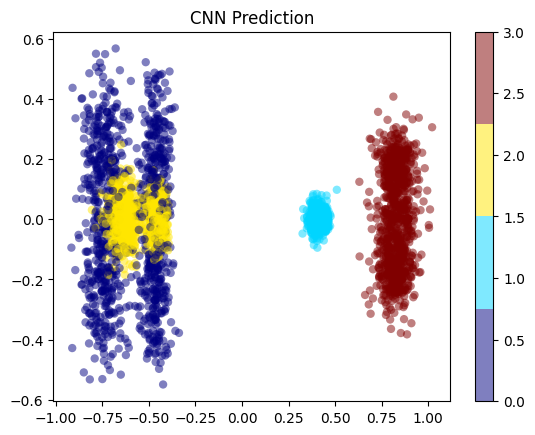

In [130]:
def plot_data(x, y, title):
    pca = PCA(n_components = 2)
    projected = pca.fit_transform(x)
    plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.get_cmap('jet', np.unique(y).max() + 1))
    plt.colorbar()
    plt.title(title)
    plt.show()
x_test_reshaped = val_data.reshape(val_data.shape[0], -1)
plot_data(x_test_reshaped, all_predictions, "CNN Prediction")

In [131]:
def load_data():  
    # 读取数据  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    return x, y, num  

def create_train_data(x, y, ratio=0.8):  
    num_example = x.shape[0]  
    arr = np.arange(num_example)  
    np.random.seed(50)  
    np.random.shuffle(arr)  
    arr_data = x[arr]  
    arr_label = y[arr]  

    s = int(num_example * ratio)  
    x_train = arr_data[:s]  
    y_train = arr_label[:s]  
    x_val = arr_data[s:]  
    y_val = arr_label[s:]  
    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_val.shape)  
    print("测试集类别：", Counter(y_val))  
    return x_train, y_train, x_val, y_val  

def create_loaders(train_data, train_label, val_data, val_label, batch_size):  
    # Convert to PyTorch tensors  
    train_data_tensor = torch.from_numpy(train_data).float()  
    train_label_tensor = torch.from_numpy(train_label).long()  
    val_data_tensor = torch.from_numpy(val_data).float()  
    val_label_tensor = torch.from_numpy(val_label).long()  

    # Create datasets and dataloaders  
    train_dataset = TensorDataset(train_data_tensor, train_label_tensor)  
    val_dataset = TensorDataset(val_data_tensor, val_label_tensor)  

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  

    return train_loader, val_loader  

class ResidualBlock(nn.Module):  
    def __init__(self, filters, conv_size):  
        super(ResidualBlock, self).__init__()  
        self.conv1 = nn.Conv1d(filters, filters, conv_size, padding=1)  
        self.bn1 = nn.BatchNorm1d(filters)  
        self.conv2 = nn.Conv1d(filters, filters, conv_size, padding=1)  
        self.bn2 = nn.BatchNorm1d(filters)  

    def forward(self, x):  
        identity = x  
        out = self.conv1(x)  
        out = F.relu(self.bn1(out))  
        out = self.conv2(out)  
        out = self.bn2(out)  
        out += identity  
        out = F.relu(out)  
        return out  

class CNN_ResNet_model(nn.Module):  
    def __init__(self, label_num, num_b, data_shape=(20, 20)):  
        super(CNN_ResNet_model, self).__init__()  
        self.num_blocks = num_b  
        self.filters = 64  
        self.conv_size = 3  
        self.label_num = label_num  

        # Initial Conv Layers  
        self.conv1 = nn.Conv1d(data_shape[1], 32, 3)  
        self.conv2 = nn.Conv1d(32, 64, 3)  

        # Pooling Layer  
        self.pool = nn.MaxPool1d(4)  

        # ResNet Blocks  
        self.res_blocks = nn.ModuleList([ResidualBlock(self.filters, self.conv_size) for _ in range(self.num_blocks)])  

        # Additional Conv Layer after ResNet Blocks  
        self.conv3 = nn.Conv1d(64, 64, 3)  

        # Global Average Pooling  
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  

        # Fully connected layers  
        self.fc1 = nn.Linear(64, 256)  
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(256, label_num)  

    def forward(self, x):  
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  

        for block in self.res_blocks:  
            x = block(x)  

        x = F.relu(self.conv3(x))  
        x = self.global_avg_pool(x)  
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer  
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)  
        x = self.fc2(x)  
        x = F.log_softmax(x, dim=1)  

        return x  

def train_model(model, train_loader, criterion, optimizer, num_epochs):  
    for epoch in range(num_epochs):  
        model.train()  
        running_loss = 0.0  
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.permute(0, 2, 1)  # (batch_size, channels, seq_length) since Conv1d expects this format  
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item()  

        epoch_loss = running_loss / len(train_loader)  
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')  

def evaluate_model(model, val_loader):  
    model.eval()  
    correct = 0  
    total = 0  
    all_predictions = []  
    all_labels = []  

    with torch.no_grad():  
        for inputs, labels in val_loader:  
            inputs = inputs.permute(0, 2, 1)  # (batch_size, channels, seq_length)  
            outputs = model(inputs)  
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
            all_predictions.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    accuracy = 100 * correct / total  
    print(f'Test Accuracy: {accuracy:.2f}%')  

    all_predictions = np.asarray(all_predictions, dtype='int64')  
    all_labels = np.asarray(all_labels, dtype='int64')  

    print('------------------测试集上得分：------------------------')  
    print('测试集准确率: ', round(accuracy_score(all_labels, all_predictions), 3))  
    print('分类报告如下:\n', classification_report(all_labels, all_predictions))  

    result = classification_report(all_labels, all_predictions, output_dict=True)  
    evaluation_info = {}  
    evaluation_info['accuracy'] = result['accuracy']  
    evaluation_info['precision'] = result['macro avg']['precision']  
    evaluation_info['recall'] = result['macro avg']['recall']  
    evaluation_info['f1-score'] = result['macro avg']['f1-score']  
    print('简要评估信息:', evaluation_info)  

    return evaluation_info,all_predictions


data, label, label_count = load_data()  
train_data, train_label, val_data, val_label = create_train_data(data, label, 0.7)  

minibatch_size = 30  
train_loader, val_loader = create_loaders(train_data, train_label, val_data, val_label, minibatch_size)  

model = CNN_ResNet_model(label_num=4, num_b=5, data_shape=(20, 20))  # Update data_shape to (20, 20)  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.009)  
num_epochs = 50
start=time.time()
train_model(model, train_loader, criterion, optimizer, num_epochs) 
end=time.time()
train_time=end-start
print(f"train time: {train_time} s")
eval_info,all_predictions = evaluate_model(model, val_loader)  
print('最终评估信息:', eval_info)
CNN_ResNet_info={}
CNN_ResNet_info['accuracy']=eval_info['accuracy']
CNN_ResNet_info['precision']=eval_info['precision']
CNN_ResNet_info['recall']=eval_info['recall']
CNN_ResNet_info['f1-score']=eval_info['f1-score']
CNN_ResNet_info['train_time']=train_time

类别数量为： 4
训练集shape (8601, 20, 20)
训练集类别： Counter({3: 2191, 1: 2171, 0: 2138, 2: 2101})
测试集shape (3687, 20, 20)
测试集类别： Counter({2: 971, 0: 934, 1: 901, 3: 881})
Epoch 1/50, Loss: 0.6029
Epoch 2/50, Loss: 0.3410
Epoch 3/50, Loss: 0.2601
Epoch 4/50, Loss: 0.1217
Epoch 5/50, Loss: 0.0666
Epoch 6/50, Loss: 0.0709
Epoch 7/50, Loss: 0.0625
Epoch 8/50, Loss: 0.0517
Epoch 9/50, Loss: 0.0329
Epoch 10/50, Loss: 0.0875
Epoch 11/50, Loss: 0.0581
Epoch 12/50, Loss: 0.0404
Epoch 13/50, Loss: 0.0297
Epoch 14/50, Loss: 0.0400
Epoch 15/50, Loss: 0.0417
Epoch 16/50, Loss: 0.0223
Epoch 17/50, Loss: 0.0126
Epoch 18/50, Loss: 0.0098
Epoch 19/50, Loss: 0.0132
Epoch 20/50, Loss: 0.0144
Epoch 21/50, Loss: 0.0063
Epoch 22/50, Loss: 0.0365
Epoch 23/50, Loss: 0.0219
Epoch 24/50, Loss: 0.0137
Epoch 25/50, Loss: 0.0324
Epoch 26/50, Loss: 0.0149
Epoch 27/50, Loss: 0.0109
Epoch 28/50, Loss: 0.0064
Epoch 29/50, Loss: 0.0044
Epoch 30/50, Loss: 0.0050
Epoch 31/50, Loss: 0.0057
Epoch 32/50, Loss: 0.0090
Epoch 33/50, Loss:

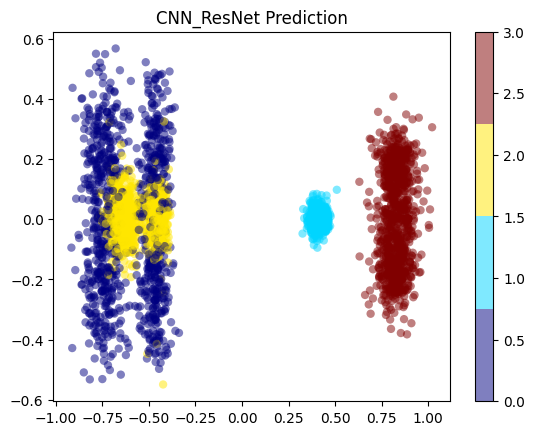

In [132]:
def plot_data(x, y, title):
    pca = PCA(n_components = 2)
    projected = pca.fit_transform(x)
    plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.get_cmap('jet', np.unique(y).max() + 1))
    plt.colorbar()
    plt.title(title)
    plt.show()
x_test_reshaped = val_data.reshape(val_data.shape[0], -1)
plot_data(x_test_reshaped, all_predictions, "CNN_ResNet Prediction")

类别数量为： 4


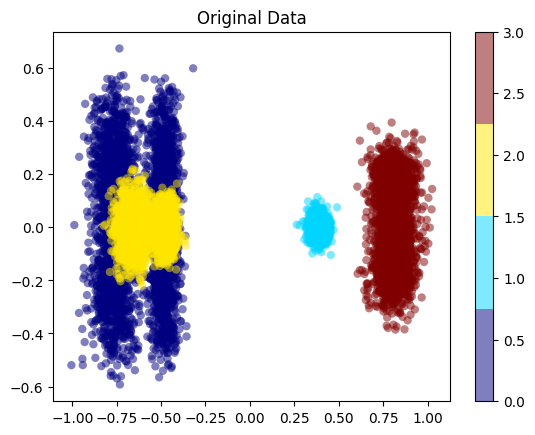

训练集shape (9830, 20, 20)
训练集类别： Counter({0: 2482, 2: 2475, 1: 2446, 3: 2427})
测试集shape (2458, 20, 20)
测试集类别： Counter({3: 645, 1: 626, 2: 597, 0: 590})
train time: 7.361278057098389 s
测试集准确率: 0.9877949552481693
分类报告如下:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       590
           1       1.00      1.00      1.00       626
           2       0.95      1.00      0.98       597
           3       1.00      1.00      1.00       645

    accuracy                           0.99      2458
   macro avg       0.99      0.99      0.99      2458
weighted avg       0.99      0.99      0.99      2458



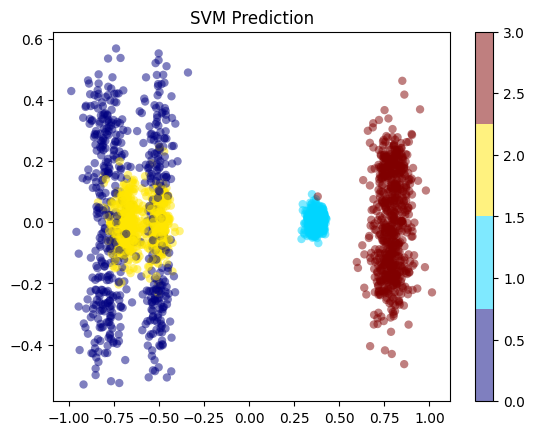

In [111]:
import numpy as np  
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score, classification_report  
from sklearn.model_selection import train_test_split  
from collections import Counter  
import matplotlib.pyplot as plt  
from sklearn.decomposition import PCA  

# 加载数据  
def load_data():  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    return x, y, num  

# 切分训练集和测试集  
def split_data(x, y, test_size=0.2):  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=50)  
    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_test.shape)  
    print("测试集类别：", Counter(y_test))  
    return x_train, x_test, y_train, y_test  

# 使用PCA将数据压缩至二维以便可视化  
def plot_data(x, y, title):  
    pca = PCA(n_components = 2)  
    projected = pca.fit_transform(x)  
    plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,   
                cmap=plt.get_cmap('jet', np.unique(y).max() + 1))  
    plt.colorbar()  
    plt.title(title)  
    plt.show()  


x, y, _ = load_data()  

# 展示原始数据的分布情况  
plot_data(x.reshape(x.shape[0], -1), y, "Original Data")  

x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.2)  

# 将二维数据 reshape 成 1D 特征向量  
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)  
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)  

# 创建 SVM 模型并进行训练  
model = SVC(kernel='rbf', random_state=50)
start=time.time()
model.fit(x_train_reshaped, y_train)  
end=time.time()
train_time=end-start
print(f'train time: {train_time} s')
# 对测试集进行预测  
y_pred = model.predict(x_test_reshaped)  

# 输出测试结果  
print("测试集准确率:", accuracy_score(y_test, y_pred))  
print("分类报告如下:\n", classification_report(y_test, y_pred))  
result=classification_report(y_test, y_pred,output_dict=True)
SVM_info={}
SVM_info['accuracy']=result['accuracy']
SVM_info['precision']=result['macro avg']['precision']
SVM_info['recall']=result['macro avg']['recall']
SVM_info['f1-score']=result['macro avg']['f1-score']
SVM_info['train_time']=train_time
# 可视化 SVM 分类结果  
plot_data(x_test_reshaped, y_pred, "SVM Prediction")  

类别数量为： 4


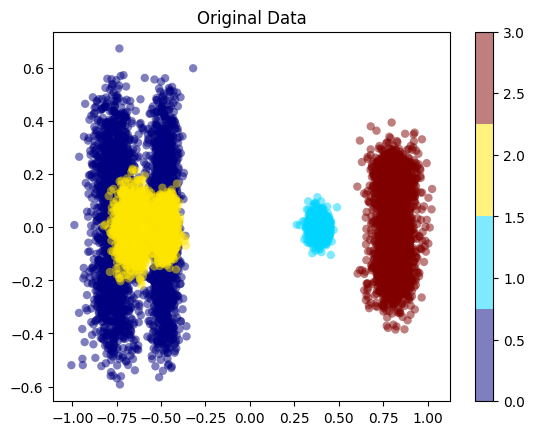

训练集shape (8601, 20, 20)
训练集类别： Counter({3: 2175, 2: 2162, 0: 2142, 1: 2122})
测试集shape (3687, 20, 20)
测试集类别： Counter({1: 950, 0: 930, 2: 910, 3: 897})
train time : 0.0015048980712890625 s
测试集准确率: 0.7664768104149715
分类报告如下:
               precision    recall  f1-score   support

           0       1.00      0.09      0.16       930
           1       0.99      1.00      0.99       950
           2       0.52      1.00      0.68       910
           3       1.00      0.98      0.99       897

    accuracy                           0.77      3687
   macro avg       0.88      0.77      0.71      3687
weighted avg       0.88      0.77      0.71      3687



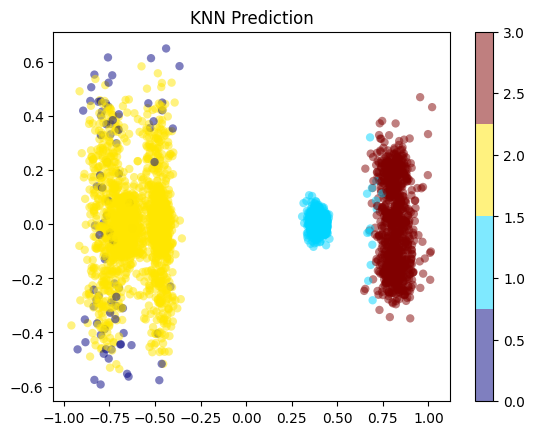

In [112]:
import numpy as np  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score, classification_report  
from sklearn.model_selection import train_test_split  
from collections import Counter  
import matplotlib.pyplot as plt  
from sklearn.decomposition import PCA  

# 加载数据  
def load_data():  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    return x, y, num  

# 切分训练集和测试集  
def split_data(x, y, test_size=0.2):  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)  
    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_test.shape)  
    print("测试集类别：", Counter(y_test))  
    return x_train, x_test, y_train, y_test  

# 使用PCA将数据压缩至二维以便可视化  
def plot_data(x, y, title):  
    pca = PCA(n_components=2)  
    projected = pca.fit_transform(x)  
    plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,   
                cmap=plt.get_cmap('jet', np.unique(y).max() + 1))  
    plt.colorbar()  
    plt.title(title)  
    plt.show()  

# 主函数  

x, y, _ = load_data()  

# 展示原始数据的分布情况  
plot_data(x.reshape(x.shape[0], -1), y, "Original Data")  

x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.3)  

# 将二维数据 reshape 成 1D 特征向量  
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)  
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)  

# 创建 KNN 模型并进行训练  
model = KNeighborsClassifier(n_neighbors=2)  # 使用默认的 5 个邻居  
start=time.time()
model.fit(x_train_reshaped, y_train)  
end=time.time()
train_time=end-start
print(f'train time : {train_time} s')
# 对测试集进行预测  
y_pred = model.predict(x_test_reshaped)  

# 输出测试结果  
print("测试集准确率:", accuracy_score(y_test, y_pred))  
print("分类报告如下:\n", classification_report(y_test, y_pred,zero_division=0))  
result=classification_report(y_test, y_pred,output_dict=True)
KNN_info={}
KNN_info['accuracy']=result['accuracy']
KNN_info['precision']=result['macro avg']['precision']
KNN_info['recall']=result['macro avg']['recall']
KNN_info['f1-score']=result['macro avg']['f1-score']
KNN_info['train_time']=train_time
# 可视化 SVM 分类结果  
# 可视化 KNN 分类结果  
plot_data(x_test_reshaped, y_pred, "KNN Prediction")  

类别数量为： 4


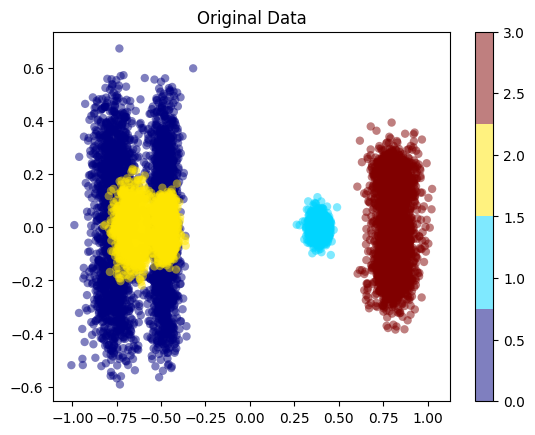

训练集shape (9830, 20, 20)
训练集类别： Counter({2: 2480, 3: 2471, 1: 2448, 0: 2431})
测试集shape (2458, 20, 20)
测试集类别： Counter({0: 641, 1: 624, 3: 601, 2: 592})
train time: 11.695483446121216s
测试集准确率: 0.8925956061838893
分类报告如下:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       641
           1       1.00      0.98      0.99       624
           2       0.91      0.64      0.75       592
           3       0.98      1.00      0.99       601

    accuracy                           0.89      2458
   macro avg       0.91      0.89      0.89      2458
weighted avg       0.90      0.89      0.89      2458



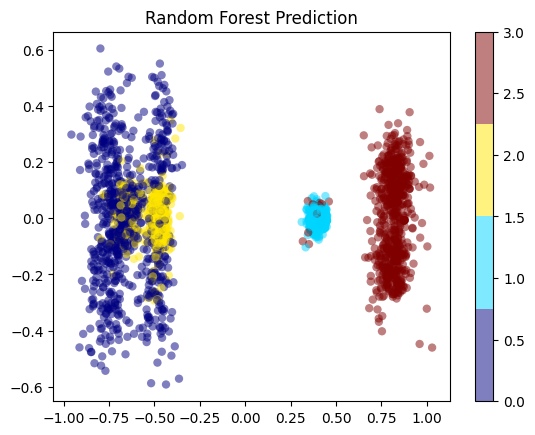

In [136]:
import numpy as np  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report  
from sklearn.model_selection import train_test_split  
from collections import Counter  
import matplotlib.pyplot as plt  
from sklearn.decomposition import PCA  

# 加载数据  
def load_data():  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    return x, y, num  

# 切分训练集和测试集  
def split_data(x, y, test_size=0.2):  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)  
    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_test.shape)  
    print("测试集类别：", Counter(y_test))  
    return x_train, x_test, y_train, y_test  

# 使用PCA将数据压缩至二维以便可视化  
def plot_data(x, y, title):  
    pca = PCA(n_components=2)  
    projected = pca.fit_transform(x)  
    plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,   
                cmap=plt.get_cmap('jet', np.unique(y).max() + 1))  
    plt.colorbar()  
    plt.title(title)  
    plt.show()  

# 主函数  
 
x, y, _ = load_data()  

# 展示原始数据的分布情况  
plot_data(x.reshape(x.shape[0], -1), y, "Original Data")  

x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.2)  

# 将二维数据 reshape 成 1D 特征向量  
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)  
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)  

# 创建随机森林模型并进行训练  
model = RandomForestClassifier(n_estimators=100, random_state=42)  
start=time.time()
model.fit(x_train_reshaped, y_train)  
end=time.time()
train_time=end-start
print(f'train time: {train_time}s')
# 对测试集进行预测  
y_pred = model.predict(x_test_reshaped)  

# 输出测试结果  
print("测试集准确率:", accuracy_score(y_test, y_pred))  
print("分类报告如下:\n", classification_report(y_test, y_pred))  
result=classification_report(y_test, y_pred,output_dict=True)
rfc_info={}
rfc_info['accuracy']=result['accuracy']
rfc_info['precision']=result['macro avg']['precision']
rfc_info['recall']=result['macro avg']['recall']
rfc_info['f1-score']=result['macro avg']['f1-score']
rfc_info['train_time']=train_time

# 可视化随机森林分类结果  
plot_data(x_test_reshaped, y_pred, "Random Forest Prediction")  

类别数量为： 4


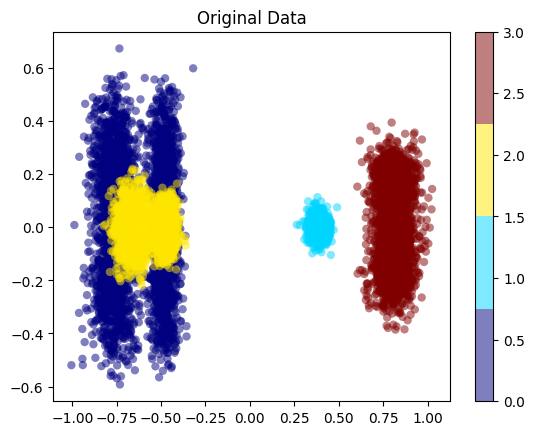

训练集shape (9830, 400)
训练集类别： Counter({2: 2480, 3: 2471, 1: 2448, 0: 2431})
测试集shape (2458, 400)
测试集类别： Counter({0: 641, 1: 624, 3: 601, 2: 592})
train time: 0.05304408073425293 s
Test Accuracy: 76.69%
分类报告如下:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58       641
           1       0.99      0.96      0.97       624
           2       0.55      0.55      0.55       592
           3       0.95      0.99      0.97       601

    accuracy                           0.77      2458
   macro avg       0.77      0.77      0.77      2458
weighted avg       0.77      0.77      0.77      2458



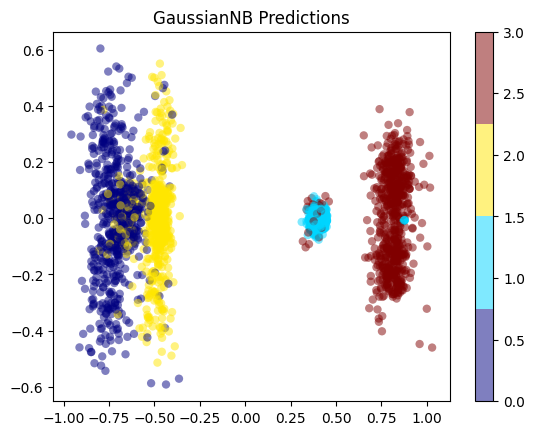

In [114]:
import numpy as np  
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import classification_report  
from sklearn.model_selection import train_test_split  
from sklearn.decomposition import PCA  
import matplotlib.pyplot as plt  
from collections import Counter  

# 加载数据  
def load_data():  
    x = np.load('train_data/data_2d_10class.npy')  
    y = np.load('train_data/labels_2d_10class.npy')  
    num = len(Counter(y))  
    print("类别数量为：", num)  
    return x, y, num  

# 切分训练集和测试集  
def split_data(x, y, test_size=0.2):  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)  
    print("训练集shape", x_train.shape)  
    print("训练集类别：", Counter(y_train))  
    print("测试集shape", x_test.shape)  
    print("测试集类别：", Counter(y_test))  
    return x_train, x_test, y_train, y_test  

# 训练和评估模型  
def train_and_evaluate_model(x_train, y_train, x_test, y_test):  
    
    model = GaussianNB()
    
   
    start=time.time()
    model.fit(x_train, y_train)
    end=time.time()
    train_time=end-start
    print(f'train time: {train_time} s')
    predictions = model.predict(x_test)  

    print(f'Test Accuracy: {model.score(x_test, y_test) * 100:.2f}%')  
    print('分类报告如下:\n', classification_report(y_test, predictions))  
    
    return y_test, predictions,train_time

# 使用PCA将数据压缩至二维以便可视化  
def plot_data(x, y, title):  
    if min(x.shape[0], x.shape[1]) > 1:  
        pca = PCA(n_components=2)  
        projected = pca.fit_transform(x)  
        plt.scatter(projected[:, 0], projected[:, 1], c=y, edgecolor='none', alpha=0.5,   
                    cmap=plt.get_cmap('jet', np.unique(y).max() + 1))  
        plt.colorbar()  
        plt.title(title)  
        plt.show()  
    else:  
        print("数据样本数或特征数不足以进行PCA降维")  

# 主函数  

# 加载和拆分数据  
x, y, _ = load_data()  
    
# 将三维数据重塑为二维 （例如将 (样本数, 高度, 宽度) 转换为 (样本数, 高度*宽度)）  
x = x.reshape(x.shape[0], -1)  

plot_data(x, y, "Original Data")  
x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.2)  
# 训练和评估模型  
all_labels, all_predictions,train_time = train_and_evaluate_model(x_train, y_train, x_test, y_test) 
result=classification_report(y_test,all_predictions,output_dict=True)
gb_info={}
gb_info['accuracy']=result['accuracy']
gb_info['precision']=result['macro avg']['precision']
gb_info['recall']=result['macro avg']['recall']
gb_info['f1-score']=result['macro avg']['f1-score']
gb_info['train_time']=train_time
plot_data(x_test.reshape(x_test.shape[0], -1), all_predictions, "GaussianNB Predictions")  

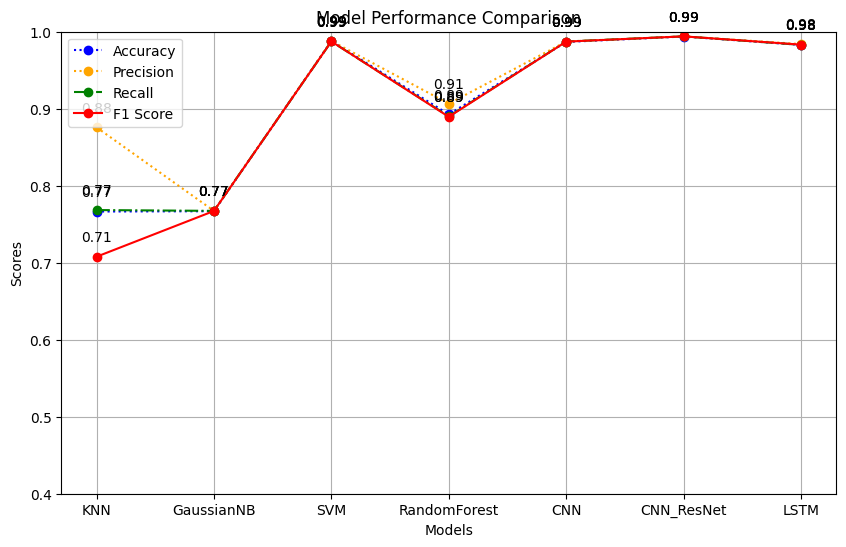

In [137]:
results = {'KNN':KNN_info,'GaussianNB':gb_info,'SVM':SVM_info,'RandomForest':rfc_info,'CNN':CNN_info,'CNN_ResNet':CNN_ResNet_info,'LSTM':LSTM_info}

model_names = list(results.keys())  
accuracy = [results[model]['accuracy'] for model in model_names]  
precision = [results[model]['precision'] for model in model_names]  
recall = [results[model]['recall'] for model in model_names]  
f1_score = [results[model]['f1-score'] for model in model_names]  
# train_time=[results[model]['train_time'] for model in model_names]
# 设置 X 轴位置  
x = np.arange(len(model_names))  

# 设置宽度  
width = 0.2  

# 创建图形和轴  
plt.figure(figsize=(10, 6))  

# 绘制折线图  
plt.plot(model_names, accuracy, marker='o', label='Accuracy', linestyle='dotted', color='blue')  
plt.plot(model_names, precision, marker='o', label='Precision', linestyle=':', color='orange')  
plt.plot(model_names, recall, marker='o', label='Recall', linestyle='-.', color='green')  
plt.plot(model_names, f1_score, marker='o', label='F1 Score', linestyle='-', color='red')  
# plt.plot(model_names, train_time, marker='o', label='Train Time', linestyle='--', color='purple')

# 添加标题和标签  
plt.title('Model Performance Comparison')  
plt.xlabel('Models')  
plt.ylabel('Scores')  
plt.ylim(0.40, 1)  

# 图例  
plt.legend()  

# 显示数值标签  
for i, (acc, prec, rec, f1) in enumerate(zip(accuracy, precision, recall, f1_score)):  
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')  
    plt.text(i, prec + 0.02, f'{prec:.2f}', ha='center')  
    plt.text(i, rec + 0.02, f'{rec:.2f}', ha='center')  
    plt.text(i, f1 + 0.02, f'{f1:.2f}', ha='center')  
    # plt.text(i, train_time[i] + 0.02, f'{train_time[i]:.2f}', ha='center')


# 显示图形  
 
plt.grid()  
plt.show()  

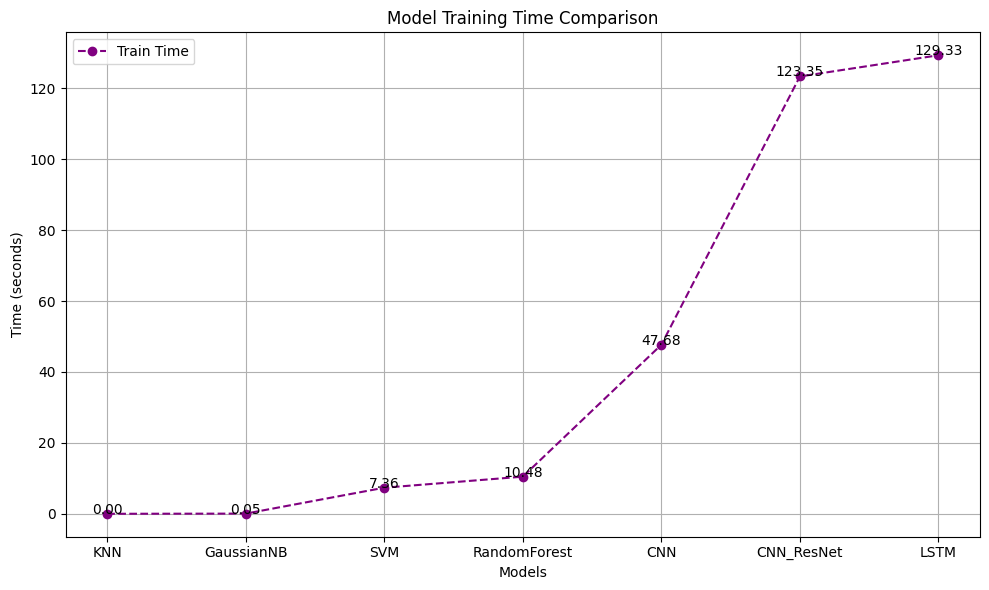

In [134]:
train_time=[results[model]['train_time'] for model in model_names]
# 创建图形和轴
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_time, marker='o', label='Train Time', linestyle='--', color='purple')
# 添加标题和标签
plt.title('Model Training Time Comparison')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
# 图例
plt.legend()
# 显示数值标签
for i, ttime in enumerate(train_time):
    plt.text(i, ttime , f'{ttime:.2f}', ha='center')
# 显示图形
plt.tight_layout()
plt.grid()
plt.show()
